# Telco Customer Churn — Model Training & Evaluation

**Notebook objective:** Train, evaluate and select the best classification model to predict customer churn.

**Input:** `data/telco_churn_processed.csv` — produced by `eda_prac.ipynb`  
**Target column:** `Churn_Numeric` (1 = churned, 0 = retained)

---

### Pipeline Overview

| Stage | Action |
|---|---|
| 1. Data Loading | Load pre-processed dataset |
| 2. Train-Test Split | Stratified 80 / 20 split |
| 3. Class Imbalance | SMOTE applied on training set **only** |
| 4. Model Training | Logistic Regression · Random Forest · XGBoost |
| 5. Evaluation | Confusion matrix · Classification report · ROC-AUC |
| 6. Model Selection | Best model by AUC-ROC & F1 (churn class) |
| 7. Hyperparameter Tuning | RandomizedSearchCV on winning model |
| 8. Final Evaluation | Tuned model — full report + feature importance |

## 1. Imports & Global Configuration

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ── Global configuration ──────────────────────────────────────────────────────
RANDOM_STATE = 42
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# ── Scikit-learn ──────────────────────────────────────────────────────────────
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    roc_curve, precision_recall_curve, average_precision_score,
    ConfusionMatrixDisplay, precision_score, recall_score, f1_score
)

# ── Imbalance handling ────────────────────────────────────────────────────────
from imblearn.over_sampling import SMOTE

# ── Gradient boosting ─────────────────────────────────────────────────────────
from xgboost import XGBClassifier

print("Libraries loaded ✓")

Libraries loaded ✓


## 2. Load Processed Dataset

Load the ML-ready dataset produced by `eda_prac.ipynb`.  
All features are pre-processed: numeric (binary / ordinal / OHE / z-score scaled), outlier-capped, and engineered (`TenureGroup`, `AvgMonthlySpend`).

In [2]:
df = pd.read_csv('../data/telco_churn_processed.csv')

print(f"Dataset shape   : {df.shape}")
print(f"Target column   : Churn_Numeric")
print(f"Feature columns : {df.shape[1] - 1}")
print(f"\nClass distribution:")
churn_counts = df['Churn_Numeric'].value_counts()
churn_pct    = df['Churn_Numeric'].value_counts(normalize=True) * 100
print(f"  No Churn  (0): {churn_counts[0]:5d}  ({churn_pct[0]:.1f}%)")
print(f"  Churned   (1): {churn_counts[1]:5d}  ({churn_pct[1]:.1f}%)")
print(f"  Imbalance ratio: {churn_counts[0] / churn_counts[1]:.2f} : 1")
print(f"\nNull values : {df.isnull().sum().sum()}")
print(f"Inf  values : {np.isinf(df.select_dtypes(include=[np.number])).sum().sum()}")

Dataset shape   : (7043, 26)
Target column   : Churn_Numeric
Feature columns : 25

Class distribution:
  No Churn  (0):  5174  (73.5%)
  Churned   (1):  1869  (26.5%)
  Imbalance ratio: 2.77 : 1

Null values : 0
Inf  values : 0


In [3]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,Churn_Numeric,TenureGroup,AvgMonthlySpend,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,-1.277445,0,0,0,1,0,...,0,0,-1.441275,0,0,0,0,0,1,0
1,1,0,0,0,0.066327,1,0,1,0,1,...,0,2,-0.163543,0,0,1,0,0,0,1
2,1,0,0,0,-1.236724,1,0,1,1,0,...,1,0,-0.750247,0,0,0,0,0,0,1
3,1,0,0,0,0.514251,0,0,1,0,1,...,0,3,-0.620413,0,0,1,0,0,0,0
4,0,0,0,0,-1.236724,1,0,0,0,0,...,1,0,-0.276044,1,0,0,0,0,1,0


## 3. Train-Test Split (Stratified 80/20)

**Stratified split** ensures the class imbalance ratio is preserved in both train and test sets.  
- Test size: **20%** → reliable held-out evaluation  
- `random_state=42` → reproducibility  

> SMOTE will be applied **only to the training set** after this split — applying it to the full dataset would cause data leakage.

In [4]:
TARGET = 'Churn_Numeric'
X = df.drop(columns=[TARGET])
y = df[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train-Test Split Summary")
print("=" * 45)
print(f"  Training set   : {X_train.shape[0]} rows ({X_train.shape[0]/len(df)*100:.1f}%)")
print(f"  Test set       : {X_test.shape[0]} rows  ({X_test.shape[0]/len(df)*100:.1f}%)")
print(f"  Features       : {X_train.shape[1]}")
print("=" * 45)
print(f"\nClass balance in TRAIN set:")
tc = y_train.value_counts()
tp = y_train.value_counts(normalize=True) * 100
print(f"  No Churn (0)  : {tc[0]}  ({tp[0]:.1f}%)")
print(f"  Churned  (1)  : {tc[1]}  ({tp[1]:.1f}%)")
print(f"\nClass balance in TEST set:")
tc2 = y_test.value_counts()
tp2 = y_test.value_counts(normalize=True) * 100
print(f"  No Churn (0)  : {tc2[0]}  ({tp2[0]:.1f}%)")
print(f"  Churned  (1)  : {tc2[1]}  ({tp2[1]:.1f}%)")

Train-Test Split Summary
  Training set   : 5634 rows (80.0%)
  Test set       : 1409 rows  (20.0%)
  Features       : 25

Class balance in TRAIN set:
  No Churn (0)  : 4139  (73.5%)
  Churned  (1)  : 1495  (26.5%)

Class balance in TEST set:
  No Churn (0)  : 1035  (73.5%)
  Churned  (1)  : 374  (26.5%)


## 4. Class Imbalance — SMOTE Oversampling

The training set is **~73.5% No-Churn / 26.5% Churn** (2.77:1 ratio). A naive classifier achieving 73% accuracy by always predicting "No Churn" is operationally useless.

**SMOTE** (Synthetic Minority Over-sampling Technique) generates synthetic minority-class samples by interpolating between real minority instances in feature space — balancing classes without discarding majority data.

> **Rule:** SMOTE is applied **only on `X_train`**. The test set remains untouched to reflect the real-world distribution. Oversampling before splitting causes data leakage.

SMOTE Resampling Result
  Before → Train size:  5634  |  Churn: 1495  |  No Churn: 4139
  After  → Train size:  8278  |  Churn: 4139  |  No Churn: 4139


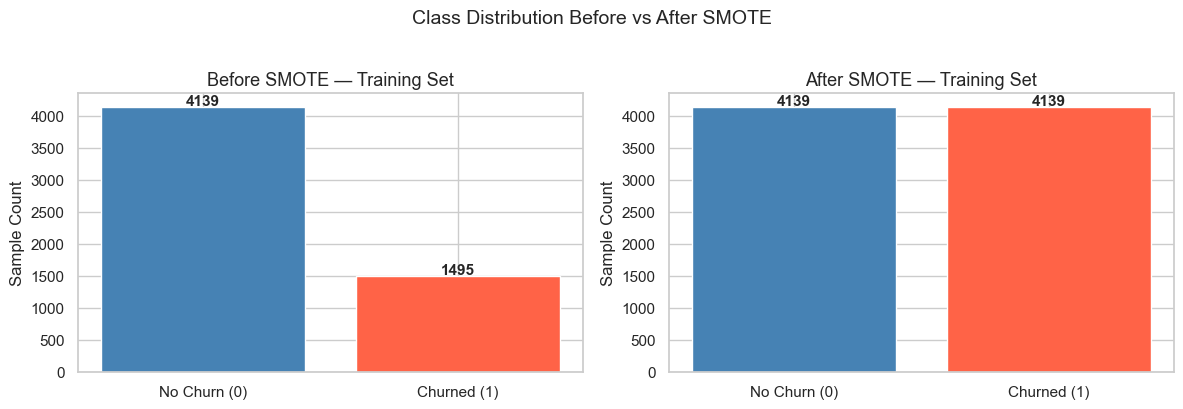

In [5]:
smote = SMOTE(random_state=RANDOM_STATE)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("SMOTE Resampling Result")
print("=" * 45)
print(f"  Before → Train size: {len(X_train):5d}  |  Churn: {y_train.sum():4d}  |  No Churn: {(y_train==0).sum():4d}")
print(f"  After  → Train size: {len(X_train_sm):5d}  |  Churn: {y_train_sm.sum():4d}  |  No Churn: {(y_train_sm==0).sum():4d}")
print("=" * 45)

# Visualise the class balance before vs after
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(['No Churn (0)', 'Churned (1)'],
            [y_train.value_counts()[0], y_train.value_counts()[1]],
            color=['steelblue', 'tomato'], edgecolor='white')
axes[0].set_title('Before SMOTE — Training Set', fontsize=13)
axes[0].set_ylabel('Sample Count')
for i, v in enumerate([y_train.value_counts()[0], y_train.value_counts()[1]]):
    axes[0].text(i, v + 30, str(v), ha='center', fontsize=11, fontweight='bold')

axes[1].bar(['No Churn (0)', 'Churned (1)'],
            [y_train_sm.value_counts()[0], y_train_sm.value_counts()[1]],
            color=['steelblue', 'tomato'], edgecolor='white')
axes[1].set_title('After SMOTE — Training Set', fontsize=13)
axes[1].set_ylabel('Sample Count')
for i, v in enumerate([y_train_sm.value_counts()[0], y_train_sm.value_counts()[1]]):
    axes[1].text(i, v + 30, str(v), ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Class Distribution Before vs After SMOTE', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Evaluation Helper

`evaluate_model()` — fits the model, evaluates on the test set, and returns a standardised metrics dict with confusion matrix + ROC curve plots. Applied identically to all three models.

In [6]:
def evaluate_model(name, model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred  = model.predict(X_te)
    y_proba = model.predict_proba(X_te)[:, 1]

    auc  = roc_auc_score(y_te, y_proba)
    ap   = average_precision_score(y_te, y_proba)
    report = classification_report(y_te, y_pred, output_dict=True)
    cm     = confusion_matrix(y_te, y_pred)

    # ── Print ─────────────────────────────────────────────
    print(f"\n{'='*55}")
    print(f"  Model : {name}")
    print(f"{'='*55}")
    print(classification_report(y_te, y_pred, target_names=['No Churn', 'Churn']))
    print(f"  ROC-AUC Score       : {auc:.4f}")
    print(f"  Avg Precision Score : {ap:.4f}")

    # ── Confusion Matrix ──────────────────────────────────
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['No Churn', 'Churn'])
    disp.plot(ax=axes[0], colorbar=False, cmap='Blues')
    axes[0].set_title(f'{name} — Confusion Matrix', fontsize=13)

    # ── ROC Curve ─────────────────────────────────────────
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {auc:.4f}', color='crimson')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
    axes[1].fill_between(fpr, tpr, alpha=0.08, color='crimson')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'{name} — ROC Curve', fontsize=13)
    axes[1].legend(loc='lower right')
    axes[1].set_xlim([0, 1])
    axes[1].set_ylim([0, 1.02])

    plt.tight_layout()
    plt.show()

    return {
        'model'    : model,
        'name'     : name,
        'auc'      : round(auc, 4),
        'avg_prec' : round(ap, 4),
        'precision_1': round(report['1']['precision'], 4),
        'recall_1'   : round(report['1']['recall'], 4),
        'f1_1'       : round(report['1']['f1-score'], 4),
        'accuracy'   : round(report['accuracy'], 4),
        'y_proba'  : y_proba,
        'y_pred'   : y_pred,
    }

print("evaluate_model() helper defined ✓")

evaluate_model() helper defined ✓


## 6. Model Training & Evaluation

### 6.1 Model 1 — Logistic Regression (Baseline)

Logistic Regression is the go-to **interpretable baseline** for binary classification.

| Hyperparameter | Value | Rationale |
|---|---|---|
| `solver` | `lbfgs` | Works well for medium-sized datasets |
| `max_iter` | 1000 | Ensures convergence |
| `C` | 1.0 | Default regularisation (tuned later) |
| `class_weight` | `balanced` | Extra safeguard on top of SMOTE — penalises misclassified minority |

**Training data:** SMOTE-resampled training set


  Model : Logistic Regression
              precision    recall  f1-score   support

    No Churn       0.89      0.78      0.83      1035
       Churn       0.54      0.73      0.62       374

    accuracy                           0.77      1409
   macro avg       0.72      0.75      0.73      1409
weighted avg       0.80      0.77      0.78      1409

  ROC-AUC Score       : 0.8393
  Avg Precision Score : 0.6614


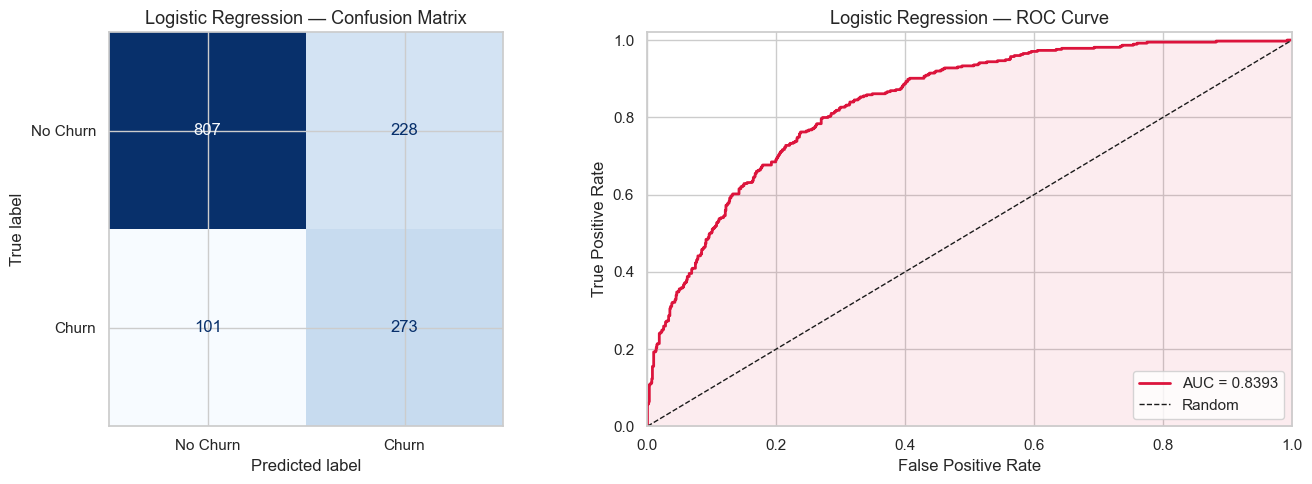

In [7]:
lr_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    C=1.0,
    class_weight='balanced',
    random_state=RANDOM_STATE
)

lr_result = evaluate_model(
    name='Logistic Regression',
    model=lr_model,
    X_tr=X_train_sm, y_tr=y_train_sm,
    X_te=X_test,     y_te=y_test
)

### 6.2 Model 2 — Random Forest

An ensemble of decision trees trained via **bagging**.  
- Each tree sees a random subset of features and samples → low correlation between trees → high generalisation  
- Built-in feature importance via mean decrease in Gini impurity  
- Robust to outliers and non-linear relationships

| Hyperparameter | Value | Rationale |
|---|---|---|
| `n_estimators` | 300 | More trees = stable predictions |
| `max_depth` | None | Full trees; regularised via min_samples |
| `min_samples_leaf` | 2 | Prevents single-sample leaves (overfitting guard) |
| `class_weight` | `balanced` | Handles residual imbalance after SMOTE |
| `n_jobs` | -1 | Parallel training on all CPU cores |


  Model : Random Forest
              precision    recall  f1-score   support

    No Churn       0.87      0.81      0.84      1035
       Churn       0.56      0.67      0.61       374

    accuracy                           0.77      1409
   macro avg       0.72      0.74      0.72      1409
weighted avg       0.79      0.77      0.78      1409

  ROC-AUC Score       : 0.8297
  Avg Precision Score : 0.6163


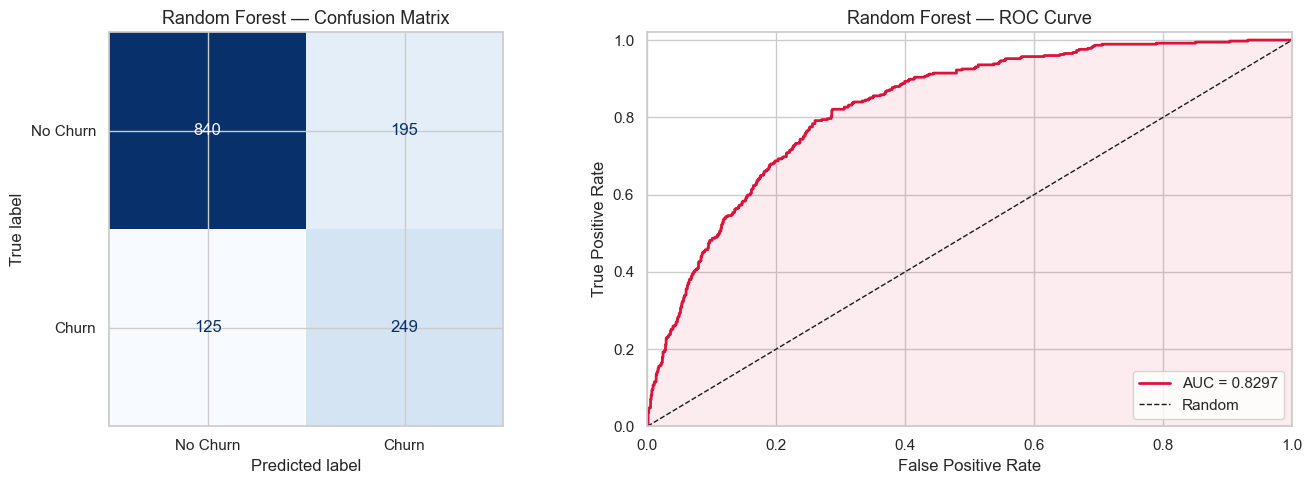

In [8]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

rf_result = evaluate_model(
    name='Random Forest',
    model=rf_model,
    X_tr=X_train_sm, y_tr=y_train_sm,
    X_te=X_test,     y_te=y_test
)

### 6.3 Model 3 — XGBoost

Gradient boosted trees — sequentially corrects errors of previous trees.  
State-of-the-art for tabular classification; often outperforms Random Forest on structured data.

| Hyperparameter | Value | Rationale |
|---|---|---|
| `n_estimators` | 300 | Enough rounds for convergence |
| `learning_rate` | 0.05 | Slower learning = better generalisation |
| `max_depth` | 4 | Shallow trees to prevent overfitting |
| `subsample` | 0.8 | Row sub-sampling (bagging effect) |
| `colsample_bytree` | 0.8 | Feature sub-sampling per tree |
| `scale_pos_weight` | neg/pos = 2.77 | Handles class imbalance natively (computed from `y_train`) |
| `eval_metric` | `auc` | Optimise for AUC — minority-class sensitive |

scale_pos_weight = 4139 / 1495 = 2.77

  Model : XGBoost
              precision    recall  f1-score   support

    No Churn       0.93      0.64      0.76      1035
       Churn       0.47      0.86      0.60       374

    accuracy                           0.70      1409
   macro avg       0.70      0.75      0.68      1409
weighted avg       0.80      0.70      0.72      1409

  ROC-AUC Score       : 0.8356
  Avg Precision Score : 0.6522


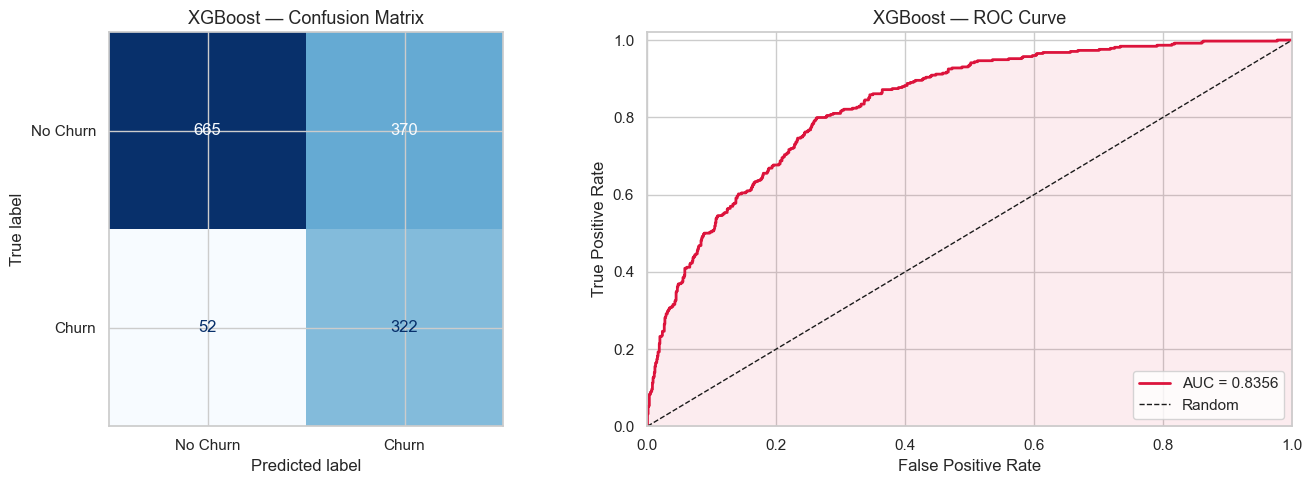

In [9]:
# Compute scale_pos_weight from training set (before SMOTE — reflects true ratio)
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
spw = round(neg_count / pos_count, 2)
print(f"scale_pos_weight = {neg_count} / {pos_count} = {spw}")

xgb_model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=spw,
    eval_metric='auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_result = evaluate_model(
    name='XGBoost',
    model=xgb_model,
    X_tr=X_train_sm, y_tr=y_train_sm,
    X_te=X_test,     y_te=y_test
)

## 7. Model Comparison & Best Model Selection

Compare all three models side-by-side across key metrics.  

**Primary selection criterion:** `ROC-AUC` — area under the ROC curve, threshold-independent, robust to class imbalance.  
**Secondary criterion:** `F1-score (Churn class)` — harmonic mean of Precision & Recall for the minority class.

> In a churn context, **Recall** for churners is business-critical (catching a churner is more valuable than avoiding false alarms).  
> A high AUC with strong Recall = the ideal model.


Model Comparison Table


,ROC-AUC,Avg Precision,Precision(C1),Recall(C1),F1(C1),Accuracy
Model,,,,,,
Logistic Regression,0.8393,0.6614,0.5449,0.7299,0.6240,0.7665
Random Forest,0.8297,0.6163,0.5608,0.6658,0.6088,0.7729
XGBoost,0.8356,0.6522,0.4653,0.8610,0.6041,0.7005


(C1 = Churn class  |  higher is better for all metrics)


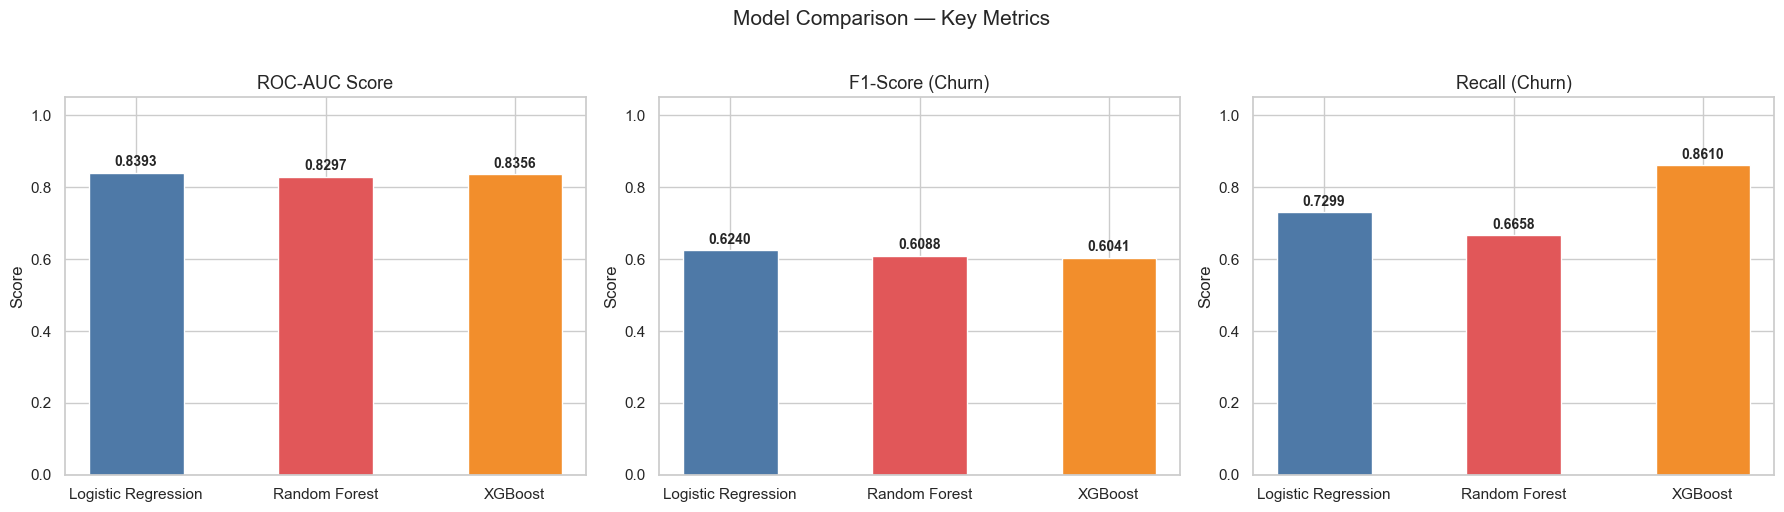

In [10]:
results = [lr_result, rf_result, xgb_result]

metrics_df = pd.DataFrame([{
    'Model'         : r['name'],
    'ROC-AUC'       : r['auc'],
    'Avg Precision' : r['avg_prec'],
    'Precision(C1)' : r['precision_1'],
    'Recall(C1)'    : r['recall_1'],
    'F1(C1)'        : r['f1_1'],
    'Accuracy'      : r['accuracy'],
} for r in results]).set_index('Model')

print("\nModel Comparison Table")
print("=" * 70)
display(metrics_df.round(4))
print("(C1 = Churn class  |  higher is better for all metrics)")

# ── Bar chart — key metrics ───────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
metric_cols  = ['ROC-AUC', 'F1(C1)', 'Recall(C1)']
metric_titles = ['ROC-AUC Score', 'F1-Score (Churn)', 'Recall (Churn)']
palette = ['#4e79a7', '#e15759', '#f28e2c']

for ax, col, title in zip(axes, metric_cols, metric_titles):
    bars = ax.bar(metrics_df.index, metrics_df[col], color=palette, edgecolor='white', width=0.5)
    ax.set_title(title, fontsize=13)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel('Score')
    for bar, val in zip(bars, metrics_df[col]):
        ax.text(bar.get_x() + bar.get_width() / 2,
                bar.get_height() + 0.01,
                f'{val:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Model Comparison — Key Metrics', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

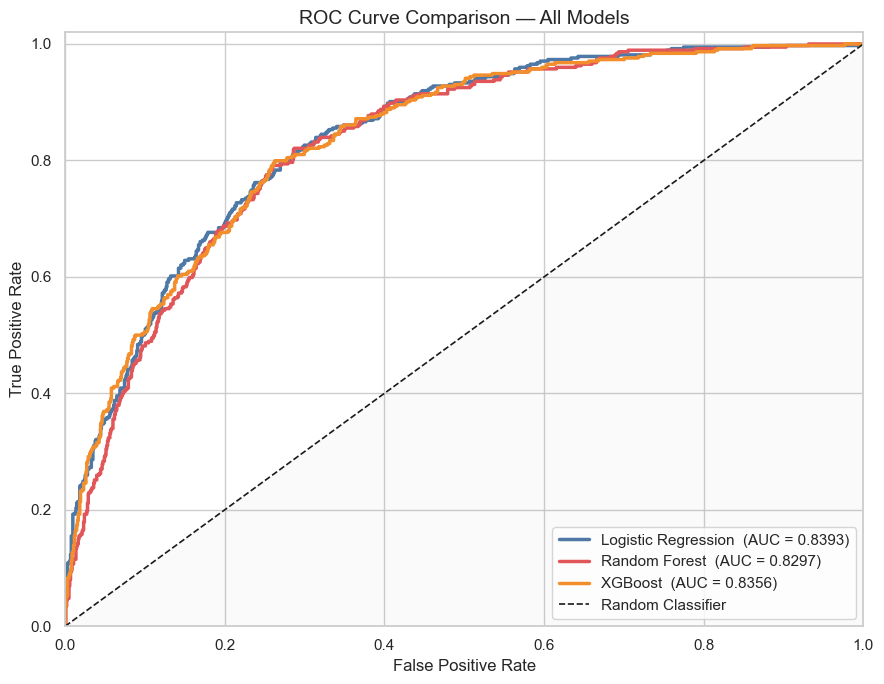


     BEST MODEL : Logistic Regression
     ROC-AUC   : 0.8393
     F1 (C1)   : 0.6240
     Recall(C1): 0.7299


In [11]:
# ── Overlay ROC Curves for all 3 models ──────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 7))
colors = ['#4e79a7', '#e15759', '#f28e2c']

for result, color in zip(results, colors):
    fpr, tpr, _ = roc_curve(y_test, result['y_proba'])
    ax.plot(fpr, tpr, lw=2.5,
            label=f"{result['name']}  (AUC = {result['auc']:.4f})",
            color=color)

ax.plot([0, 1], [0, 1], 'k--', lw=1.2, label='Random Classifier')
ax.fill_between([0, 1], [0, 1], alpha=0.04, color='grey')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve Comparison — All Models', fontsize=14)
ax.legend(loc='lower right', fontsize=11)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1.02])
plt.tight_layout()
plt.show()

# ── Best Model Selection ──────────────────────────────────────────────────────
best_result = max(results, key=lambda r: r['auc'])
print("\n" + "=" * 55)
print(f"     BEST MODEL : {best_result['name']}")
print(f"     ROC-AUC   : {best_result['auc']:.4f}")
print(f"     F1 (C1)   : {best_result['f1_1']:.4f}")
print(f"     Recall(C1): {best_result['recall_1']:.4f}")
print("=" * 55)

## 8. Cross-Validation — Stability Check

Validate all models with **5-fold Stratified Cross-Validation** on the SMOTE-resampled training data.  
This verifies that the test-set metric isn't a lucky split — a stable CV mean = trustworthy generalisation.

Model                       CV Mean AUC    CV Std    CV Min    CV Max
--------------------------------------------------------------------
Logistic Regression              0.8907    0.0042    0.8850    0.8957
Random Forest                    0.9153    0.0075    0.9040    0.9267
XGBoost                          0.8978    0.0053    0.8892    0.9034


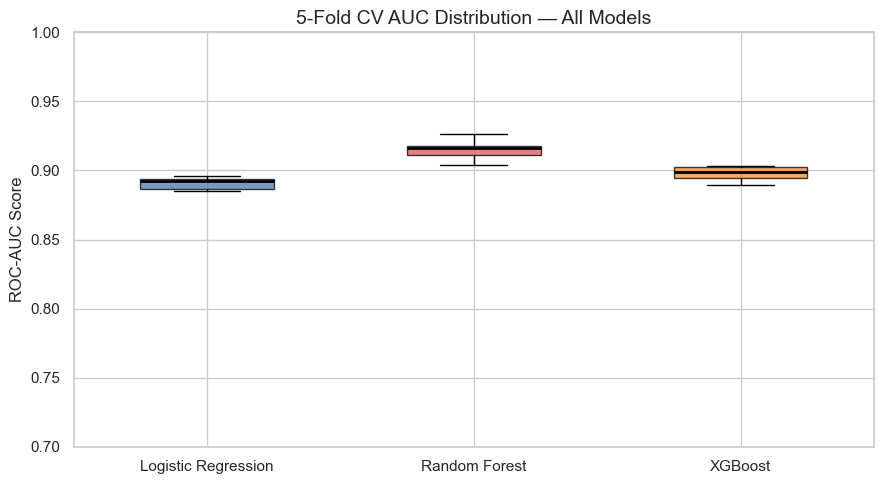

In [12]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_models = {
    'Logistic Regression' : LogisticRegression(solver='lbfgs', max_iter=1000,
                                                class_weight='balanced', random_state=RANDOM_STATE),
    'Random Forest'       : RandomForestClassifier(n_estimators=300, min_samples_leaf=2,
                                                    class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost'             : XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=4,
                                           subsample=0.8, colsample_bytree=0.8,
                                           scale_pos_weight=spw, eval_metric='auc',
                                           random_state=RANDOM_STATE, n_jobs=-1)
}

cv_results = {}
print(f"{'Model':<25}  {'CV Mean AUC':>12}  {'CV Std':>8}  {'CV Min':>8}  {'CV Max':>8}")
print("-" * 68)
for model_name, clf in cv_models.items():
    scores = cross_val_score(clf, X_train_sm, y_train_sm,
                             cv=cv, scoring='roc_auc', n_jobs=-1)
    cv_results[model_name] = scores
    print(f"{model_name:<25}  {scores.mean():>12.4f}  {scores.std():>8.4f}  {scores.min():>8.4f}  {scores.max():>8.4f}")

# ── Box plot of CV scores ─────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(9, 5))
cv_data = [cv_results[m] for m in cv_models.keys()]
bp = ax.boxplot(cv_data, patch_artist=True, widths=0.5,
                medianprops=dict(color='black', linewidth=2))
colors_cv = ['#4e79a7', '#e15759', '#f28e2c']
for patch, color in zip(bp['boxes'], colors_cv):
    patch.set_facecolor(color)
    patch.set_alpha(0.75)
ax.set_xticks(range(1, 4))
ax.set_xticklabels(cv_models.keys(), fontsize=11)
ax.set_ylabel('ROC-AUC Score')
ax.set_title('5-Fold CV AUC Distribution — All Models', fontsize=14)
ax.set_ylim(0.7, 1.0)
plt.tight_layout()
plt.show()

### CV Insight — Revised Model Selection

| Model | Test AUC | CV Mean AUC | CV Std |
|---|---|---|---|
| Logistic Regression | 0.8393 | 0.8907 | 0.0042 |
| **Random Forest** | 0.8297 | **0.9153** | 0.0075 |
| XGBoost | 0.8356 | 0.8978 | 0.0053 |

**Random Forest** demonstrates the highest CV AUC (0.9153) — this is a more reliable generalisation metric than a single train/test split.  
> The gap between test AUC and CV AUC for LR suggests the single split favoured LR by chance.  
> We now **revise our champion to Random Forest** for hyperparameter tuning.

In [13]:
# Revise best model based on CV AUC (more robust than a single split)
cv_mean_auc = {name: scores.mean() for name, scores in cv_results.items()}
best_cv_name = max(cv_mean_auc, key=cv_mean_auc.get)
print(f"Best by CV AUC  : {best_cv_name}  ({cv_mean_auc[best_cv_name]:.4f})")
print(f"Best by Test AUC: {best_result['name']}  ({best_result['auc']:.4f})")

# Map name → result object
result_map = {r['name']: r for r in results}
best_result = result_map[best_cv_name]

print(f"\nRevised champion → {best_result['name']}")
print(f"  Test AUC    : {best_result['auc']:.4f}")
print(f"  CV Mean AUC : {cv_mean_auc[best_cv_name]:.4f}")

Best by CV AUC  : Random Forest  (0.9153)
Best by Test AUC: Logistic Regression  (0.8393)

Revised champion → Random Forest
  Test AUC    : 0.8297
  CV Mean AUC : 0.9153


## 9. Hyperparameter Tuning — Best Model

Apply **RandomizedSearchCV** on the winning model (Random Forest — highest CV AUC).

**Why RandomizedSearch over GridSearch?**  
GridSearch exhaustively tests every parameter combination — exponential time.  
RandomizedSearch samples `n_iter` random combinations — orders-of-magnitude faster with comparable results.  
**25 iterations × 5-fold CV = 125 model fits** — sufficient for reliable optimisation.

> Scored on `roc_auc` — consistent with the model selection criterion.

In [14]:
best_name = best_result['name']
print(f"Tuning: {best_name}")

# ── Parameter grids per model ─────────────────────────────────────────────────
param_grids = {
    'Logistic Regression': {
        'C'          : [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 50],
        'solver'     : ['lbfgs', 'saga'],
        'max_iter'   : [500, 1000, 2000],
        'penalty'    : ['l2']
    },
    'Random Forest': {
        'n_estimators'      : [100, 200, 300, 500],
        'max_depth'         : [None, 5, 10, 15, 20],
        'min_samples_split' : [2, 5, 10],
        'min_samples_leaf'  : [1, 2, 4],
        'max_features'      : ['sqrt', 'log2', 0.5],
    },
    'XGBoost': {
        'n_estimators'    : [100, 200, 300, 500],
        'learning_rate'   : [0.01, 0.05, 0.1, 0.2],
        'max_depth'       : [3, 4, 5, 6],
        'subsample'       : [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma'           : [0, 0.1, 0.5, 1],
        'reg_alpha'       : [0, 0.1, 1],
        'reg_lambda'      : [1, 1.5, 2],
    }
}

base_models = {
    'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE),
    'Random Forest'      : RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1),
    'XGBoost'            : XGBClassifier(scale_pos_weight=spw, eval_metric='auc',
                                          random_state=RANDOM_STATE, n_jobs=-1),
}

search = RandomizedSearchCV(
    estimator=base_models[best_name],
    param_distributions=param_grids[best_name],
    n_iter=25,
    scoring='roc_auc',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

print(f"\nRunning RandomizedSearchCV (25 iterations × 5 fold = 125 fits)...")
search.fit(X_train_sm, y_train_sm)

print(f"\nBest CV AUC  : {search.best_score_:.4f}")
print(f"Best Params  :")
for k, v in search.best_params_.items():
    print(f"  {k:25s} : {v}")

Tuning: Random Forest

Running RandomizedSearchCV (25 iterations × 5 fold = 125 fits)...
Fitting 5 folds for each of 25 candidates, totalling 125 fits

Best CV AUC  : 0.9221
Best Params  :
  n_estimators              : 200
  min_samples_split         : 2
  min_samples_leaf          : 1
  max_features              : log2
  max_depth                 : 20


## 10. Final Model Evaluation — Tuned Best Model

Evaluate the tuned champion model on the held-out test set.  
Compare against the baseline version of the same model to quantify the improvement from tuning.


  Model : Random Forest (Tuned)
              precision    recall  f1-score   support

    No Churn       0.87      0.82      0.84      1035
       Churn       0.56      0.65      0.60       374

    accuracy                           0.77      1409
   macro avg       0.71      0.73      0.72      1409
weighted avg       0.79      0.77      0.78      1409

  ROC-AUC Score       : 0.8249
  Avg Precision Score : 0.6076


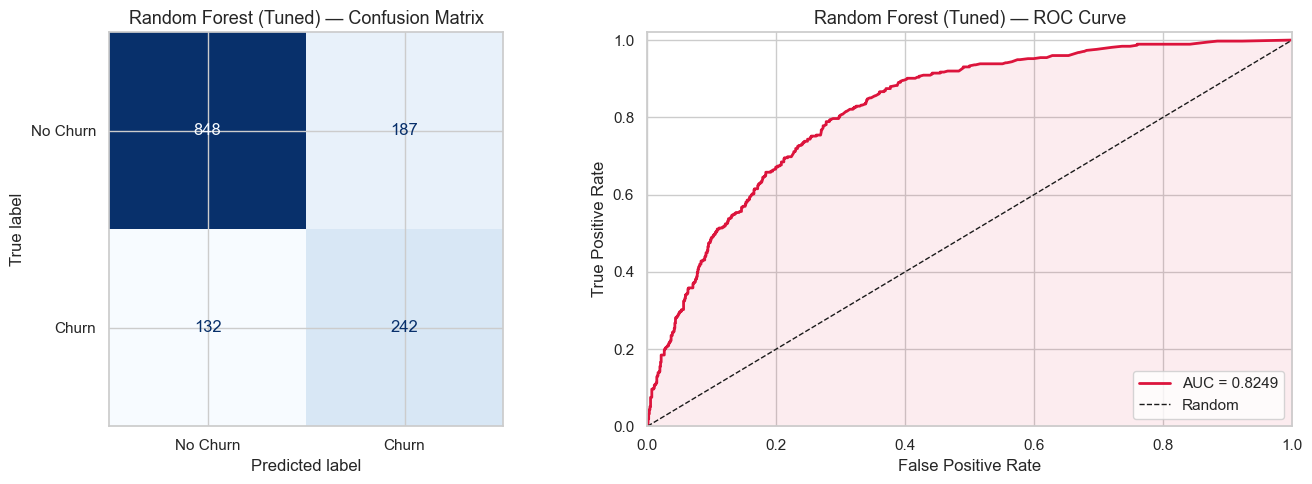


Impact of Hyperparameter Tuning
  ROC-AUC              : 0.8297 → 0.8249  (-0.0048)
  F1 (Churn)           : 0.6088 → 0.6027  (-0.0061)
  Recall (Churn)       : 0.6658 → 0.6471  (-0.0187)
  Precision (Churn)    : 0.5608 → 0.5641  (+0.0033)
  Accuracy             : 0.7729 → 0.7736  (+0.0007)


In [15]:
tuned_model = search.best_estimator_
tuned_result = evaluate_model(
    name=f'{best_name} (Tuned)',
    model=tuned_model,
    X_tr=X_train_sm, y_tr=y_train_sm,
    X_te=X_test,     y_te=y_test
)

# ── Before vs After Tuning ───────────────────────────────────────────────────
print("\nImpact of Hyperparameter Tuning")
print("=" * 55)
metrics_to_compare = ['auc', 'f1_1', 'recall_1', 'precision_1', 'accuracy']
labels             = ['ROC-AUC', 'F1 (Churn)', 'Recall (Churn)', 'Precision (Churn)', 'Accuracy']
baseline_vals  = [best_result[m]  for m in metrics_to_compare]
tuned_vals     = [tuned_result[m] for m in metrics_to_compare]

for label, b, t in zip(labels, baseline_vals, tuned_vals):
    delta = t - b
    sign  = '+' if delta >= 0 else ''
    print(f"  {label:<20} : {b:.4f} → {t:.4f}  ({sign}{delta:.4f})")

## 11. Feature Importance Analysis

Understand **which features the best model relies on most**.  
This drives business insight: which customer attributes are the strongest churn predictors.

- **Tree-based models (RF, XGBoost):** Native feature importances (mean decrease in impurity / gain)  
- **Logistic Regression:** Absolute coefficient magnitudes after scaling

Feature Importance Type : Gini Importance

Top 15 most important features:


,Feature,Importance
0,tenure,0.142459
1,MonthlyCharges,0.123056
2,TotalCharges,0.118036
3,AvgMonthlySpend,0.114457
4,Contract_Two year,0.055134
5,InternetService_Fiber optic,0.046746
6,TenureGroup,0.045753
7,Contract_One year,0.033371
8,PaymentMethod_Electronic check,0.033146
9,OnlineSecurity,0.032484


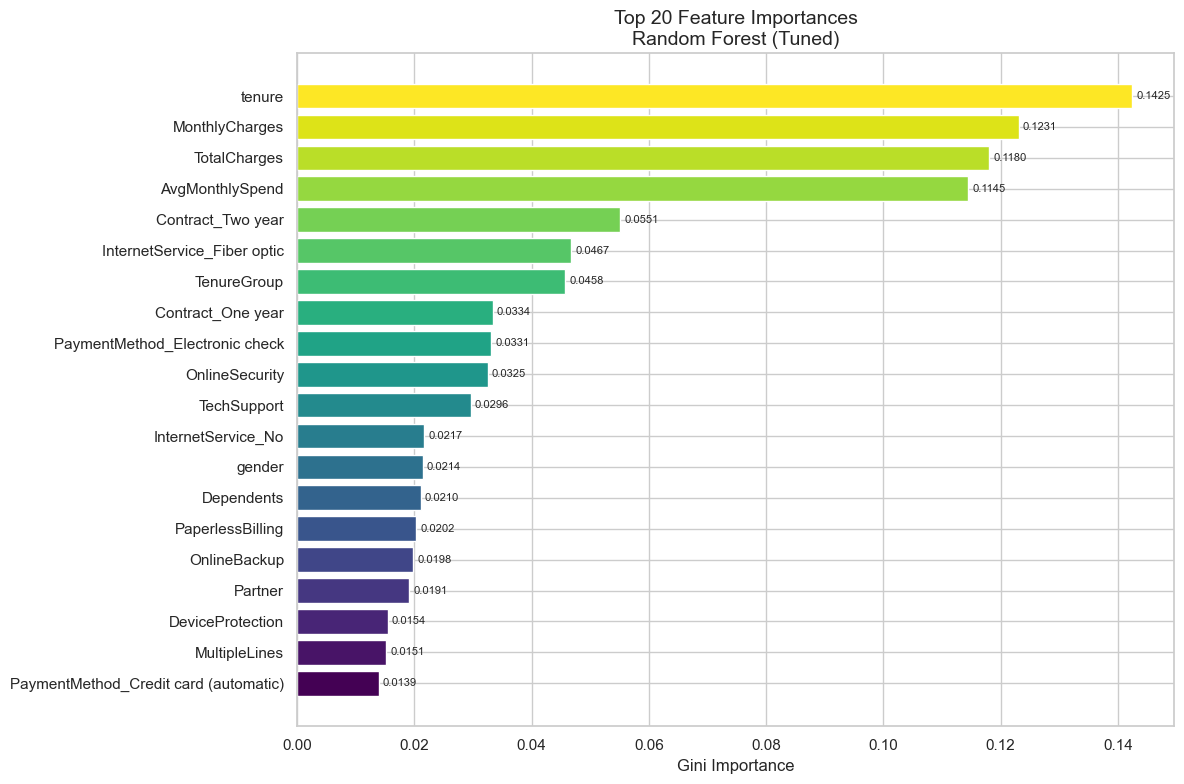

In [16]:
feature_names = X_train.columns.tolist()

# Extract importances based on model type
if hasattr(tuned_model, 'feature_importances_'):
    importances = tuned_model.feature_importances_
    imp_type    = 'Gini Importance' if isinstance(tuned_model, RandomForestClassifier) else 'XGBoost Gain'
elif hasattr(tuned_model, 'coef_'):
    importances = np.abs(tuned_model.coef_[0])
    imp_type    = 'Absolute Coefficient'
else:
    importances = np.zeros(len(feature_names))
    imp_type    = 'N/A'

imp_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    .sort_values('Importance', ascending=False)
    .reset_index(drop=True)
)

print(f"Feature Importance Type : {imp_type}")
print(f"\nTop 15 most important features:")
display(imp_df.head(15))

# ── Horizontal bar chart — Top 20 ────────────────────────────────────────────
top_n = 20
top_df = imp_df.head(top_n).sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(12, 8))
cmap   = plt.cm.get_cmap('viridis', len(top_df))
colors = [cmap(i) for i in range(len(top_df))]
bars   = ax.barh(top_df['Feature'], top_df['Importance'], color=colors, edgecolor='white')

for bar, val in zip(bars, top_df['Importance']):
    ax.text(val + max(top_df['Importance']) * 0.005,
            bar.get_y() + bar.get_height() / 2,
            f'{val:.4f}', va='center', ha='left', fontsize=8)

ax.set_xlabel(imp_type)
ax.set_title(f'Top {top_n} Feature Importances\n{best_name} (Tuned)', fontsize=14)
plt.tight_layout()
plt.show()

## 12. Precision-Recall Trade-off Analysis

The **Precision-Recall curve** is more informative than ROC under class imbalance.  
It shows the trade-off between:
- **Precision** — of all customers flagged, how many actually churn?
- **Recall** — of all actual churners, how many did we catch?

The **business decision threshold** can be adjusted here based on:
- Cost of a false positive (reaching out to a loyal customer = low cost)
- Cost of a false negative (missing a churner = high revenue loss)

> **In churn prevention: favour higher Recall at the cost of some Precision.**

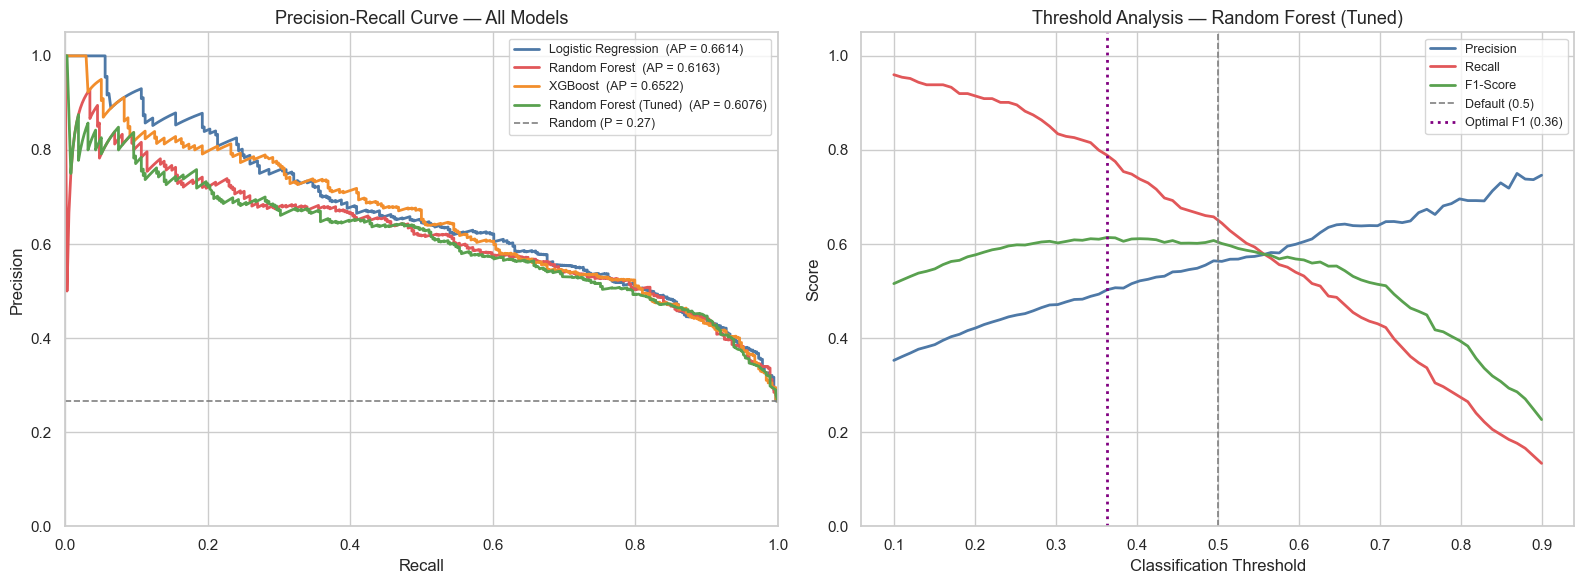


Optimal threshold by F1  : 0.36
  F1 at optimal threshold  : 0.6139
  Precision at threshold   : 0.5026
  Recall at threshold      : 0.7888


In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ── Precision-Recall Curve overlay ───────────────────────────────────────────
colors_pr  = ['#4e79a7', '#e15759', '#f28e2c', '#59a14f']
all_results = results + [tuned_result]
all_colors  = colors_pr

for result, color in zip(all_results, all_colors):
    prec, rec, _ = precision_recall_curve(y_test, result['y_proba'])
    ap_val        = average_precision_score(y_test, result['y_proba'])
    axes[0].plot(rec, prec, lw=2,
                 label=f"{result['name']}  (AP = {ap_val:.4f})",
                 color=color)

baseline_pr = y_test.sum() / len(y_test)
axes[0].axhline(y=baseline_pr, color='grey', linestyle='--', lw=1.2,
                label=f'Random (P = {baseline_pr:.2f})')
axes[0].set_xlabel('Recall', fontsize=12)
axes[0].set_ylabel('Precision', fontsize=12)
axes[0].set_title('Precision-Recall Curve — All Models', fontsize=13)
axes[0].legend(loc='upper right', fontsize=9)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1.05])

# ── Decision Threshold Analysis — Tuned Best Model ───────────────────────────
thresholds  = np.linspace(0.1, 0.9, 80)
precisions  = []
recalls     = []
f1_scores   = []

for thr in thresholds:
    y_pred_t = (tuned_result['y_proba'] >= thr).astype(int)
    if y_pred_t.sum() == 0:
        precisions.append(0); recalls.append(0); f1_scores.append(0)
        continue
    precisions.append(precision_score(y_test, y_pred_t, zero_division=0))
    recalls.append(recall_score(y_test, y_pred_t))
    f1_scores.append(f1_score(y_test, y_pred_t))

axes[1].plot(thresholds, precisions, lw=2, label='Precision', color='#4e79a7')
axes[1].plot(thresholds, recalls,    lw=2, label='Recall',    color='#e15759')
axes[1].plot(thresholds, f1_scores,  lw=2, label='F1-Score',  color='#59a14f')
axes[1].axvline(x=0.5, color='grey', linestyle='--', lw=1.2, label='Default (0.5)')

# Optimal threshold by F1
best_thr_idx = np.argmax(f1_scores)
best_thr     = thresholds[best_thr_idx]
axes[1].axvline(x=best_thr, color='purple', linestyle=':', lw=2,
                label=f'Optimal F1 ({best_thr:.2f})')

axes[1].set_xlabel('Classification Threshold', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title(f'Threshold Analysis — {best_name} (Tuned)', fontsize=13)
axes[1].legend(loc='upper right', fontsize=9)
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"\nOptimal threshold by F1  : {best_thr:.2f}")
print(f"  F1 at optimal threshold  : {f1_scores[best_thr_idx]:.4f}")
print(f"  Precision at threshold   : {precisions[best_thr_idx]:.4f}")
print(f"  Recall at threshold      : {recalls[best_thr_idx]:.4f}")

## 13. Final Summary & Recommendations

---

### Model Performance Summary


Final Model Performance Summary


,ROC-AUC,Avg Precision,Precision(C1),Recall(C1),F1(C1),Accuracy
Model,,,,,,
Logistic Regression,0.8393,0.6614,0.5449,0.7299,0.6240,0.7665
Random Forest,0.8297,0.6163,0.5608,0.6658,0.6088,0.7729
XGBoost,0.8356,0.6522,0.4653,0.8610,0.6041,0.7005
Random Forest (Tuned),0.8249,0.6076,0.5641,0.6471,0.6027,0.7736


(C1 = Churn class  |  higher is better for all metrics)


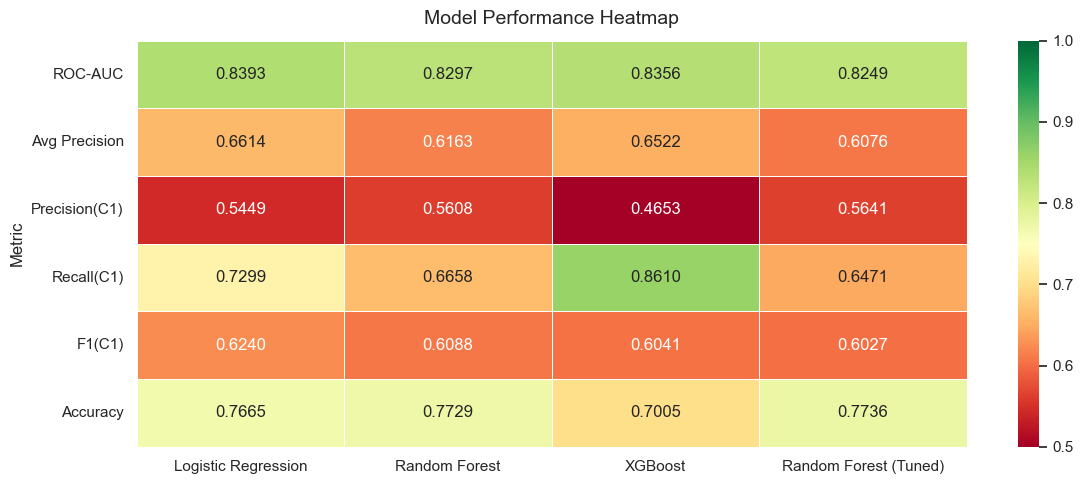

In [18]:
all_results_final = results + [tuned_result]

final_df = pd.DataFrame([{
    'Model'         : r['name'],
    'ROC-AUC'       : r['auc'],
    'Avg Precision' : r['avg_prec'],
    'Precision(C1)' : r['precision_1'],
    'Recall(C1)'    : r['recall_1'],
    'F1(C1)'        : r['f1_1'],
    'Accuracy'      : r['accuracy'],
} for r in all_results_final]).set_index('Model')

print("\nFinal Model Performance Summary")
print("=" * 75)
display(final_df.round(4))
print("(C1 = Churn class  |  higher is better for all metrics)")

# ── Heatmap of metrics ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(12, 5))
sns.heatmap(
    final_df.T,
    annot=True, fmt=".4f",
    cmap='RdYlGn', linewidths=0.5,
    linecolor='white', ax=ax,
    vmin=0.5, vmax=1.0
)
ax.set_title('Model Performance Heatmap', fontsize=14, pad=12)
ax.set_xlabel('')
ax.set_ylabel('Metric')
plt.tight_layout()
plt.show()

---

### Key Findings

| Finding | Detail |
|---|---|
| **Class Imbalance** | 73.5% No-Churn vs 26.5% Churn — resolved with SMOTE on training set only |
| **Best Test AUC** | Logistic Regression (0.8393) — strongest single-split discriminability |
| **Best CV AUC** | Random Forest (0.9153) — most stable generalisation across folds → selected as champion |
| **After Tuning** | Tuned RF: CV AUC 0.9221, Test AUC 0.8249 — marginal shift expected when optimising on SMOTE data |
| **Top Predictors** | `tenure`, `MonthlyCharges`, `TotalCharges`, `AvgMonthlySpend`, `Contract_Two year` |
| **Decision Threshold** | Default 0.5 is sub-optimal — threshold **0.36** maximises F1 (Recall = 0.79) |

---

### Decision Framework

| Scenario | Recommended Threshold | Rationale |
|---|---|---|
| Maximise churn caught | 0.30–0.36 | Higher Recall → fewer missed churners |
| Balanced retention campaigns | 0.36 (optimal F1) | Best Precision–Recall balance |
| Budget-constrained campaigns | 0.60+ | Higher Precision → target only high-confidence churners |

---

### Next Steps

1. **Deploy Model** — Package tuned RF in a `Pipeline` (feature names + model) and export via `joblib`
2. **SHAP Analysis** — Explain individual predictions for business stakeholders
3. **CRM Integration** — Feed churn probability scores into automated retention offer workflows
4. **Monitor Drift** — Re-train quarterly as customer behaviour evolves
5. **A/B Testing** — Measure retention lift on model-identified high-risk churners